# Plot qPCR to analyze export of GAPDH transcripts (in various export system configurations)

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_GAPDH"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_GAPDH_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point", "Biological Set Name", "Starting Quantity (SQ)", "Log Starting Quantity", "SQ Mean", "SQ Std. Dev"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)
cq_raw.set_index("Well", inplace=True)

print(cq_raw.shape)
cq_raw.head()

(17, 7)


,Fluor,Target,Content,Sample,Cq,Cq Mean,Cq Std. Dev
Well,,,,,,,
A01,SYBR,GAPDH,Unkn-01,RE18-9,NaN,0.000000,0.000000
A04,SYBR,GAPDH,Unkn-04,RE18-12,NaN,0.000000,0.000000
B01,SYBR,GAPDH,Unkn-01,RE18-9,NaN,0.000000,0.000000
B04,SYBR,GAPDH,Unkn-04,RE18-12,34.241842,33.813331,0.606005
B05,SYBR,GAPDH,Unkn-05,RE18-13,34.091791,33.436873,0.926194


In [5]:
# Load metadata (includes sample names)
infile = "../preprocessed_data/qPCR_data/qPCR_GAPDH_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(6, 3)


,Sample,Condition,Replicate
0,RE18-9,Gag-MCP + mCh-MS2x12,1
1,RE18-12,Gag-MCP + mCh-MS2x12 0.3X,1
2,RE18-13,Gag-MCP + mCh-MS2x12 0.1X,1
3,cfR60-1,MMLV Gag + mCh-Psi,1
4,cfR60-2,MMLV Gag + mCh,1


# Preprocess data

## Censor values below lower limit of quantification (LLoQ)

In [6]:
# NTC has no signal. Therefore there is no background in the qPCR itself.
# Set limit of detection to the maximum cycle count (40)
LOD = 40  # maximum cycle count

In [7]:
# Set missing values in cq_raw to 40
cq_raw["Cq censored"] = cq_raw["Cq"]

cq_raw.loc[cq_raw["Cq censored"].isna(), "Cq censored"] = LOD

## Summarize technical replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary_tech = pd.DataFrame()

summary_tech["Cq Mean"] = groups["Cq"].mean()  # Calculate mean over technical replicates
summary_tech["Cq STD"] = groups["Cq"].std()  # Calculate std over technical replicates

summary_tech["Cq censored Mean"] = groups["Cq censored"].mean()  # Calculate mean over technical replicates
summary_tech["Cq censored STD"] = groups["Cq censored"].std()  # Calculate std over technical replicates

summary_tech

,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD
Sample,,,,
RE18-12,33.813331,0.606005,35.875554,3.597487
RE18-13,33.436873,0.926194,33.436873,0.926194
RE18-9,NaN,NaN,40.000000,0.000000
cfR60-1,28.377079,0.245977,28.377079,0.245977
cfR60-12,34.033417,NaN,38.011139,3.444808
cfR60-2,27.502351,0.083599,27.502351,0.083599


## Map metadata to individual replicates and summary of technical replicates

In [9]:
cq_raw = cq_raw.reset_index().set_index("Sample")
cq_raw = cq_raw.join(metadata.set_index("Sample"))
cq_raw = cq_raw.reset_index().set_index("Well")

cq_raw.head()

,Sample,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Cq censored,Condition,Replicate
Well,,,,,,,,,,
A04,RE18-12,SYBR,GAPDH,Unkn-04,NaN,0.000000,0.000000,40.000000,Gag-MCP + mCh-MS2x12 0.3X,1
B04,RE18-12,SYBR,GAPDH,Unkn-04,34.241842,33.813331,0.606005,34.241842,Gag-MCP + mCh-MS2x12 0.3X,1
C04,RE18-12,SYBR,GAPDH,Unkn-04,33.384821,33.813331,0.606005,33.384821,Gag-MCP + mCh-MS2x12 0.3X,1
B05,RE18-13,SYBR,GAPDH,Unkn-05,34.091791,33.436873,0.926194,34.091791,Gag-MCP + mCh-MS2x12 0.1X,1
C05,RE18-13,SYBR,GAPDH,Unkn-05,32.781955,33.436873,0.926194,32.781955,Gag-MCP + mCh-MS2x12 0.1X,1


In [10]:
summary_tech = summary_tech.join(metadata.set_index("Sample"))

summary_tech.head()

,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD,Condition,Replicate
Sample,,,,,,
RE18-12,33.813331,0.606005,35.875554,3.597487,Gag-MCP + mCh-MS2x12 0.3X,1
RE18-13,33.436873,0.926194,33.436873,0.926194,Gag-MCP + mCh-MS2x12 0.1X,1
RE18-9,NaN,NaN,40.000000,0.000000,Gag-MCP + mCh-MS2x12,1
cfR60-1,28.377079,0.245977,28.377079,0.245977,MMLV Gag + mCh-Psi,1
cfR60-12,34.033417,NaN,38.011139,3.444808,No DNA 2,1


## Summarize biological replicates

In [11]:
groups = summary_tech.groupby(["Condition"])  # group samples by origin

summary = pd.DataFrame()

summary["Cq Mean"] = groups["Cq Mean"].mean()  # Calculate mean over biological replicates
summary["Cq STD"] = groups["Cq STD"].mean()  # Calculate std over biological replicates

summary["Cq censored Mean"] = groups["Cq censored Mean"].mean()  # Calculate mean over biological replicates
summary["Cq censored STD"] = groups["Cq censored STD"].mean()  # Calculate std over biological replicates

summary

,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD
Condition,,,,
Gag-MCP + mCh-MS2x12,NaN,NaN,40.000000,0.000000
Gag-MCP + mCh-MS2x12 0.1X,33.436873,0.926194,33.436873,0.926194
Gag-MCP + mCh-MS2x12 0.3X,33.813331,0.606005,35.875554,3.597487
MMLV Gag + mCh,27.502351,0.083599,27.502351,0.083599
MMLV Gag + mCh-Psi,28.377079,0.245977,28.377079,0.245977
No DNA 2,34.033417,NaN,38.011139,3.444808


# Plot GAPDH exported by MMLV Gag with and without the target RNA

In [12]:
index_ordered = ["MMLV Gag + mCh-Psi", 
                 "MMLV Gag + mCh", 
                 "No DNA 2"]

data = summary.loc[index_ordered]

data = data.reset_index()

data.head()

,Condition,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD
0,MMLV Gag + mCh-Psi,28.377079,0.245977,28.377079,0.245977
1,MMLV Gag + mCh,27.502351,0.083599,27.502351,0.083599
2,No DNA 2,34.033417,NaN,38.011139,3.444808


In [13]:
data_indiv = cq_raw.reset_index().set_index("Condition").loc[index_ordered]
data_indiv = data_indiv.reset_index()

data_indiv.head()

,Condition,Well,Sample,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Cq censored,Replicate
0,MMLV Gag + mCh-Psi,G01,cfR60-1,SYBR,GAPDH,Unkn-25,28.584559,28.377079,0.245977,28.584559,1
1,MMLV Gag + mCh-Psi,G02,cfR60-1,SYBR,GAPDH,Unkn-25,28.105354,28.377079,0.245977,28.105354,1
2,MMLV Gag + mCh-Psi,G03,cfR60-1,SYBR,GAPDH,Unkn-25,28.441323,28.377079,0.245977,28.441323,1
3,MMLV Gag + mCh,G04,cfR60-2,SYBR,GAPDH,Unkn-26,27.519552,27.502351,0.083599,27.519552,1
4,MMLV Gag + mCh,G05,cfR60-2,SYBR,GAPDH,Unkn-26,27.411489,27.502351,0.083599,27.411489,1


In [14]:
# Calculate enrichment relative to "No DNA"

Cq_ref = data.set_index("Condition").loc["No DNA 2", "Cq censored Mean"]  # set reference Cq to "No DNA"

data["delta Cq"] = Cq_ref - data["Cq censored Mean"]
data_indiv["delta Cq"] = Cq_ref - data_indiv["Cq censored"]

data

,Condition,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD,delta Cq
0,MMLV Gag + mCh-Psi,28.377079,0.245977,28.377079,0.245977,9.634060
1,MMLV Gag + mCh,27.502351,0.083599,27.502351,0.083599,10.508788
2,No DNA 2,34.033417,NaN,38.011139,3.444808,0.000000


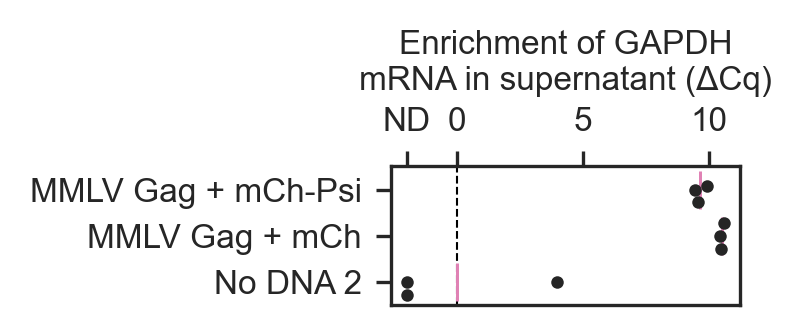

In [15]:
# Plot as Cq

fig, ax = plt.subplots(1, 1, figsize=(1.5,0.6))

sns.scatterplot(ax=ax,
                data=data,
                y="Condition",
                x="delta Cq",
                marker="|",
                s=80,
                color="#e082b5"
            )

sns.swarmplot(ax=ax,
              data=data_indiv,
              y="Condition",
              x="delta Cq",
              size=3,
              color="#252525"
            )

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_ylabel("")
ax.set_xlabel("Enrichment of GAPDH\nmRNA in supernatant (ΔCq)")

ax.set_xticks([-2, 0, 5, 10])
ax.set_xticklabels(["ND", 0, 5, 10])

ax.axvline(0, ls="--", lw=0.5, color="k", zorder=-1)

save_figure(fig, "swarmplot_GAPDH_MMLVGag")

In [16]:
# Report values and significance

condition1 = "MMLV Gag + mCh-Psi"
condition2 = "MMLV Gag + mCh"

x1 = data_indiv.set_index("Condition").loc[condition1, "Cq censored"]
x2 = data_indiv.set_index("Condition").loc[condition2, "Cq censored"]

print("Mean", condition1, x1.mean())
print("Mean", condition2, x2.mean())

print("STD", condition1, x1.std())
print("STD", condition2, x2.std())

print("Median", condition1, x1.median())
print("Median", condition2, x2.median())

print(scipy.stats.mannwhitneyu(x1, x2))

Mean MMLV Gag + mCh-Psi 28.3770788508894
Mean MMLV Gag + mCh 27.5023511709641
STD MMLV Gag + mCh-Psi 0.2459772823350045
STD MMLV Gag + mCh 0.08359946470464301
Median MMLV Gag + mCh-Psi 28.4413227876374
Median MMLV Gag + mCh 27.5195518894807
MannwhitneyuResult(statistic=9.0, pvalue=0.1)


# Plot GAPDH exported with varying target RNA expression levels

In [17]:
index_ordered = ["Gag-MCP + mCh-MS2x12", 
                 "Gag-MCP + mCh-MS2x12 0.3X",
                 "Gag-MCP + mCh-MS2x12 0.1X"]

data = summary.loc[index_ordered]

data = data.reset_index()

data.head()

,Condition,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD
0,Gag-MCP + mCh-MS2x12,NaN,NaN,40.000000,0.000000
1,Gag-MCP + mCh-MS2x12 0.3X,33.813331,0.606005,35.875554,3.597487
2,Gag-MCP + mCh-MS2x12 0.1X,33.436873,0.926194,33.436873,0.926194


In [18]:
data_indiv = cq_raw.reset_index().set_index("Condition").loc[index_ordered]
data_indiv = data_indiv.reset_index()

data_indiv.head()

,Condition,Well,Sample,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Cq censored,Replicate
0,Gag-MCP + mCh-MS2x12,A01,RE18-9,SYBR,GAPDH,Unkn-01,NaN,0.000000,0.000000,40.000000,1
1,Gag-MCP + mCh-MS2x12,B01,RE18-9,SYBR,GAPDH,Unkn-01,NaN,0.000000,0.000000,40.000000,1
2,Gag-MCP + mCh-MS2x12,C01,RE18-9,SYBR,GAPDH,Unkn-01,NaN,0.000000,0.000000,40.000000,1
3,Gag-MCP + mCh-MS2x12 0.3X,A04,RE18-12,SYBR,GAPDH,Unkn-04,NaN,0.000000,0.000000,40.000000,1
4,Gag-MCP + mCh-MS2x12 0.3X,B04,RE18-12,SYBR,GAPDH,Unkn-04,34.241842,33.813331,0.606005,34.241842,1


In [19]:
# Calculate enrichment relative to smallest cargo

Cq_ref = data.set_index("Condition").loc["Gag-MCP + mCh-MS2x12", "Cq censored Mean"]  # set reference Cq to "No DNA"

data["delta Cq"] = Cq_ref - data["Cq censored Mean"]
data_indiv["delta Cq"] = Cq_ref - data_indiv["Cq censored"]

data

,Condition,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD,delta Cq
0,Gag-MCP + mCh-MS2x12,NaN,NaN,40.000000,0.000000,0.000000
1,Gag-MCP + mCh-MS2x12 0.3X,33.813331,0.606005,35.875554,3.597487,4.124446
2,Gag-MCP + mCh-MS2x12 0.1X,33.436873,0.926194,33.436873,0.926194,6.563127


In [20]:
# Calculate inverted values so that barplot will be oriented more intuitively

data["Cq censored Mean inverted"] = 40 - data["Cq censored Mean"]
data_indiv["Cq censored inverted"] = 40 - data_indiv["Cq censored"]

data

,Condition,Cq Mean,Cq STD,Cq censored Mean,Cq censored STD,delta Cq,Cq censored Mean inverted
0,Gag-MCP + mCh-MS2x12,NaN,NaN,40.000000,0.000000,0.000000,0.000000
1,Gag-MCP + mCh-MS2x12 0.3X,33.813331,0.606005,35.875554,3.597487,4.124446,4.124446
2,Gag-MCP + mCh-MS2x12 0.1X,33.436873,0.926194,33.436873,0.926194,6.563127,6.563127


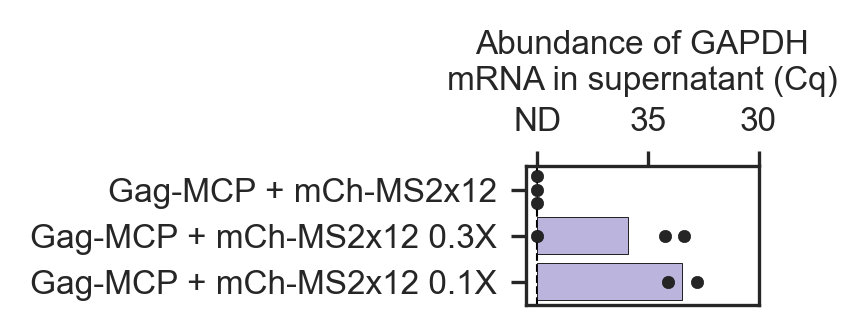

In [21]:
# Plot as Cq without mCh (without tag) and "No DNA"

data_subset = data.iloc[[0, 1, 2]]
data_indiv_subset = data_indiv.iloc[range(0,8)]

palette = ["#b7ade3", "#b7ade3", "#b7ade3"]

fig, ax = plt.subplots(1, 1, figsize=(1,0.6))

sns.barplot(ax=ax,
            data=data,
            y="Condition",
            x="Cq censored Mean inverted",
            errorbar=None,
            palette=palette,
            edgecolor="#010101",
            linewidth=0.2,
            )

sns.swarmplot(ax=ax,
              data=data_indiv,
              y="Condition",
              x="Cq censored inverted",
              edgecolor="#010101",
              linewidth=0.1,
              size=3,
              color="#252525"
            )

ax.set_xlim(-0.5, 10)
ax.set_ylabel("")
ax.set_xticks([0, 5, 10])
ax.set_xticklabels(["ND", 35, 30])

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel("Abundance of GAPDH\nmRNA in supernatant (Cq)")

ax.axvline(0, ls="--", lw=0.5, color="k", zorder=-1)

save_figure(fig, "barplot_GAPDH_vary_reporter")